In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
plt.style.use('bmh')
from scipy import stats as ss
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# the big boy stuff
import tensorflow.keras.metrics as metric
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
n = 500 # number of students
def grades(lower, upper, mean, std, n=n): # get an array of grades in a range and distribution parameters
    return [int(x) for x in (ss.truncnorm.rvs(((lower - mean) / std), ((upper - mean) / std), loc=mean, scale=std, size=n))]

### Gathering grades
#### Labs

In [3]:
Lab = dict()
for _ in range(1, 9):
    Lab[_] = grades(0, 10, 7, 3)
for key, item in Lab.items():
    print(f"Lab {key} -> {item[:10]}")

Lab 1 -> [8, 4, 5, 7, 2, 8, 7, 8, 7, 6]
Lab 2 -> [4, 5, 3, 2, 0, 6, 4, 7, 7, 8]
Lab 3 -> [7, 9, 7, 6, 7, 1, 8, 8, 6, 6]
Lab 4 -> [7, 9, 5, 3, 6, 5, 8, 9, 3, 6]
Lab 5 -> [4, 8, 4, 8, 1, 8, 5, 8, 6, 4]
Lab 6 -> [2, 6, 8, 5, 6, 2, 8, 8, 2, 9]
Lab 7 -> [7, 3, 0, 3, 6, 6, 9, 8, 4, 5]
Lab 8 -> [8, 1, 1, 9, 2, 2, 6, 7, 8, 6]


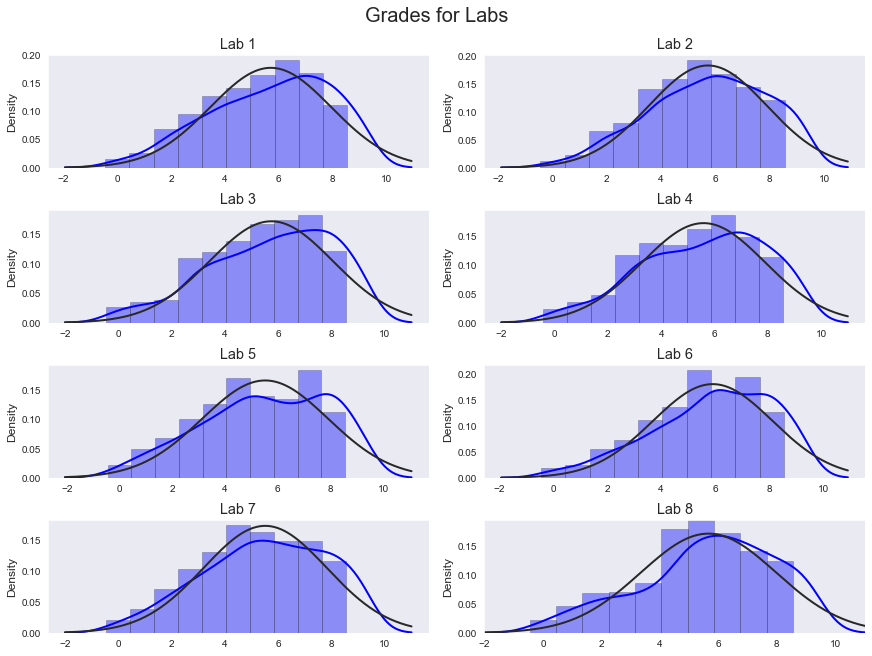

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(8):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Lab[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Lab {_+1}")
fig.suptitle('Grades for Labs', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Assignments 

In [5]:
Assignment = dict()
for _ in range(1, 5):
    Assignment[_] = grades(0, 10, 7, 3)
for key, item in Assignment.items():
    print(f"Assignment {key} -> {item[:10]}")

Assignment 1 -> [7, 9, 9, 9, 9, 8, 5, 5, 9, 9]
Assignment 2 -> [8, 6, 7, 8, 6, 6, 6, 5, 7, 6]
Assignment 3 -> [7, 6, 6, 6, 9, 8, 5, 6, 9, 7]
Assignment 4 -> [5, 9, 7, 6, 8, 7, 2, 2, 9, 3]


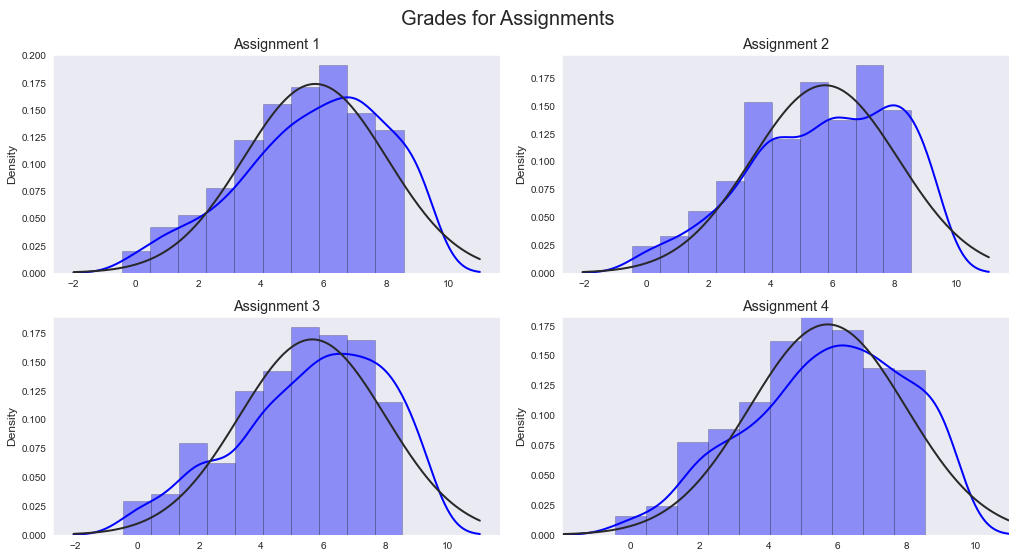

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(14, 14))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(4):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Assignment[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Assignment {_+1}")
fig.suptitle('Grades for Assignments', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Mid-Terms 

In [7]:
Mid_term = dict()
for _ in range(1, 3):
    Mid_term[_] = grades(0, 100, 75, 20)
for key, item in Mid_term.items():
    print(f"Mid-Term {key} -> {item[:10]}")

Mid-Term 1 -> [88, 56, 78, 54, 86, 92, 85, 95, 71, 55]
Mid-Term 2 -> [36, 81, 54, 83, 53, 60, 88, 65, 78, 46]


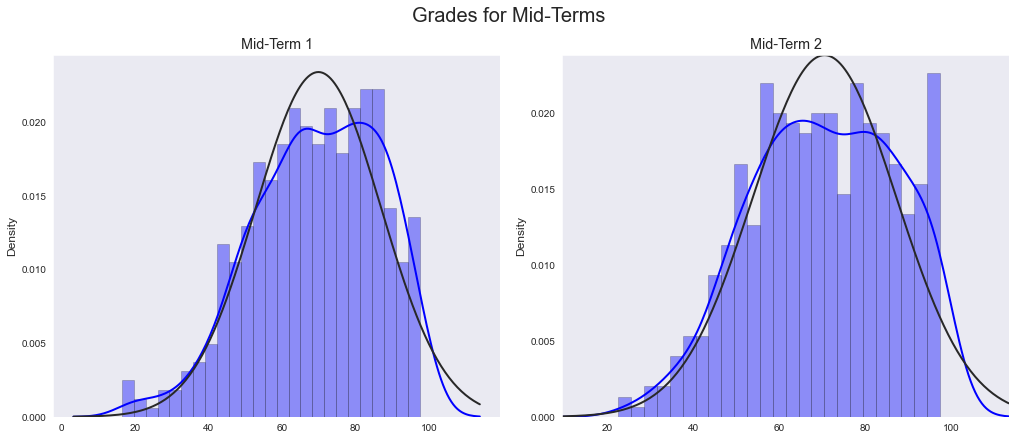

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
grid = gs(nrows=1, ncols=2, figure=fig)
for _ in range(2):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Mid_term[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=25)
    ax.set_title(f"Mid-Term {_+1}")
fig.suptitle('Grades for Mid-Terms', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Final Exam

In [9]:
Final = grades(0, 100, 65, 25)
print(f"Final Exam -> {Final[:10]}")

Final Exam -> [57, 59, 38, 55, 74, 66, 41, 77, 63, 70]


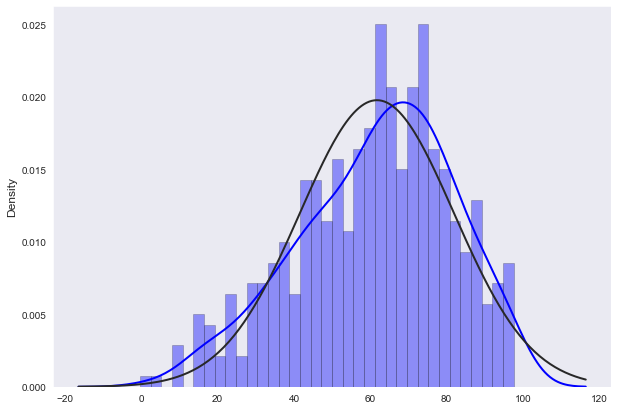

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(Final, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=35)
plt.show()

### Grade Weights 
Each type of test will contribute this much to the final grade:
* Final Exam = 30%
* Mid-Terms = 30%
* Assignments = 20%
* Labs = 20%

Total passing percentage is assumed to be **60%**

### Making the DataFrame 
#### Combining the marks togethe

In [11]:
df = pd.DataFrame(index=range(1, n+1))
df.index.name = 'Student'

# automate the process of inputting the grades for all tests for each student
for _ in range(1, 9):
    df[f"Lab {_}"] = Lab[_]

for _ in range(1, 5):
    df[f"Assignment {_}"] = Assignment[_]
    
for _ in range(1, 3):
    df[f"Mid-Term {_}"] = Mid_term[_]
    
df['Final'] = Final
    
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final
Student,,,,,,,,,,,,,,,
1,8,4,7,7,4,2,7,8,7,8,7,5,88,36,57
2,4,5,9,9,8,6,3,1,9,6,6,9,56,81,59
3,5,3,7,5,4,8,0,1,9,7,6,7,78,54,38
4,7,2,6,3,8,5,3,9,9,8,6,6,54,83,55
5,2,0,7,6,1,6,6,2,9,6,9,8,86,53,74


In [12]:
print(f"No. of students -> {len(df)}\nNumber of tests -> {df.shape[1]}")

No. of students -> 500
Number of tests -> 15


#### Determining if a student passes

In [13]:
Final_percent = 0.3
Mid_term_percent = 0.3
Assignments_percent = 0.2
Labs_percent = 0.2

Calculate the total grade for each category of test, then use that total and calculate the overall percentage of how much it contributes to students (based on the test's weightage) **overall** grade

In [14]:
lab_grades = list(df.iloc[:, :8].apply(lambda x: np.sum(x) / 80, axis=1) * Labs_percent)
assignment_grades = list(df.iloc[:, 8:12].apply(lambda x: np.sum(x) / 40, axis=1) * Assignments_percent)
mid_term_grades = list(df.iloc[:, 12:14].apply(lambda x: np.sum(x) / 200, axis=1) * Mid_term_percent)
final_grades = list(df.Final.apply(lambda x: (x / 100) * Final_percent))
lab_grades[:10]

[0.11750000000000001,
 0.1125,
 0.0825,
 0.1075,
 0.07500000000000001,
 0.095,
 0.1375,
 0.1575,
 0.1075,
 0.125]

In [15]:
overall_grades = [] # calculate the total grade percentage
for _ in range(n):
    overall_grades.append(np.round((lab_grades[_] + assignment_grades[_] + mid_term_grades[_] + final_grades[_]) * 100, 2))
overall_grades[:10]

[60.95, 64.5, 53.95, 62.3, 66.55, 66.6, 61.0, 71.85, 69.0, 61.15]

#### Finishing the final table 

In [16]:
df['Total'] = overall_grades
df['Pass/Fail'] = ["Pass" if x > 60 else "Fail" for x in overall_grades]
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,8,4,7,7,4,2,7,8,7,8,7,5,88,36,57,60.95,Pass
2,4,5,9,9,8,6,3,1,9,6,6,9,56,81,59,64.50,Pass
3,5,3,7,5,4,8,0,1,9,7,6,7,78,54,38,53.95,Fail
4,7,2,6,3,8,5,3,9,9,8,6,6,54,83,55,62.30,Pass
5,2,0,7,6,1,6,6,2,9,6,9,8,86,53,74,66.55,Pass


In [17]:
print(f"Students failed -> {len(df[df['Pass/Fail'] == 'Fail'])}\nStudents passed -> {len(df[df['Pass/Fail'] == 'Pass'])}")

Students failed -> 179
Students passed -> 321


In [18]:
df.describe().drop(['count', '25%', '50%', '75%'])

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total
mean,5.710000,5.72600,5.740000,5.58600,5.520000,5.914000,5.512000,5.660000,5.730000,5.768000,5.648000,5.718000,69.862000,70.56600,61.742000,62.360800
std,2.249449,2.17264,2.321892,2.30852,2.391032,2.217304,2.314426,2.320165,2.296879,2.368416,2.356949,2.268208,17.061922,16.76412,20.197508,7.622835
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,24.00000,1.000000,35.300000
max,9.000000,9.00000,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,99.000000,99.00000,99.000000,80.750000


### Creating excel file 

In [19]:
df.to_excel("Grades.xlsx", sheet_name='Grades')

### Making the Classifier 
#### Preprocessing

In [20]:
df_cf = df.copy()
df_cf.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term 1,Mid-Term 2,Final,Total,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,8,4,7,7,4,2,7,8,7,8,7,5,88,36,57,60.95,Pass
2,4,5,9,9,8,6,3,1,9,6,6,9,56,81,59,64.50,Pass
3,5,3,7,5,4,8,0,1,9,7,6,7,78,54,38,53.95,Fail
4,7,2,6,3,8,5,3,9,9,8,6,6,54,83,55,62.30,Pass
5,2,0,7,6,1,6,6,2,9,6,9,8,86,53,74,66.55,Pass


In [21]:
df_cf_y = LabelEncoder().fit_transform(df_cf['Pass/Fail'])
df_cf.drop(['Final', 'Total', 'Pass/Fail'], axis=1, inplace=True)
scaler = StandardScaler().fit(df_cf)
df_cf_x = scaler.transform(df_cf)
df_cf_x[0]

array([ 1.01904671, -0.79522082,  0.54320438,  0.6131272 , -0.63634543,
       -1.76697464,  0.64356779,  1.00955896,  0.55347806,  0.94334579,
        0.57419753, -0.31686654,  1.06413366, -2.06396865])

In [22]:
df_cf_x_train, df_cf_x_test, df_cf_y_train, df_cf_y_test = train_test_split(df_cf_x, df_cf_y, stratify=df_cf_y, 
                                                                           test_size=.15, random_state=7)
print(f"Train X -> {df_cf_x_train.shape}\nTrain y -> {df_cf_y_train.shape}")
print(f"Test X -> {df_cf_x_test.shape}\nTest y -> {df_cf_y_test.shape}")

Train X -> (425, 14)
Train y -> (425,)
Test X -> (75, 14)
Test y -> (75,)


#### Setting up the models
##### RandomForestClassifier

In [23]:
rfc = RandomizedSearchCV(estimator=RandomForestClassifier(),
                  param_distributions={'n_estimators':range(100, 1050, 100), 
                                       'warm_start':[True], 'criterion':['gini', 'entropy']},
                  n_jobs=-1, cv=RepeatedStratifiedKFold(random_state=7), 
                  return_train_score=True, verbose=3, n_iter=100, refit=True)
rfc.fit(df_cf_x_train, df_cf_y_train)
rfc.best_params_

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


{'warm_start': True, 'n_estimators': 600, 'criterion': 'entropy'}

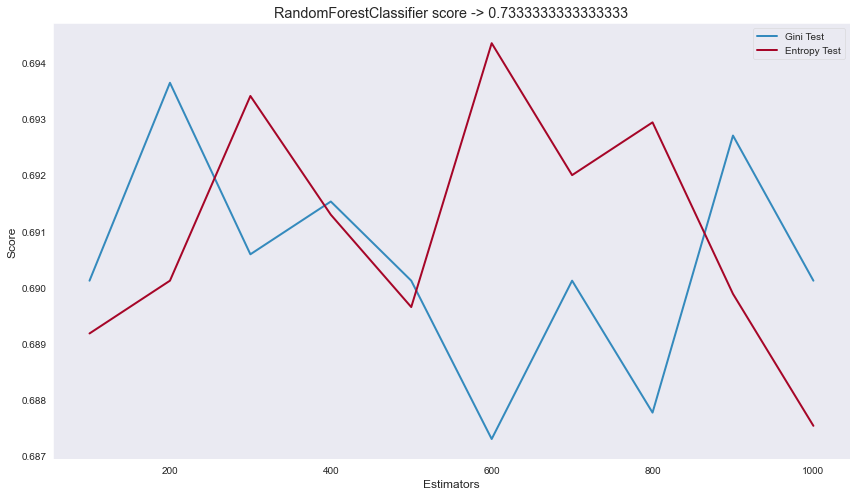

In [24]:
plt.figure(figsize=(12, 7))
plt.title(f"RandomForestClassifier score -> {rfc.score(df_cf_x_test, df_cf_y_test)}")
plt.plot(range(100, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'gini'], 
         label='Gini Test')
plt.plot(range(100, 1050, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'entropy'], 
         label='Entropy Test')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### LogisticRegressionCV 

In [25]:
logreg = LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_splits=10, random_state=7), 
                             max_iter=1000, n_jobs=-1, verbose=3, refit=True, random_state=7).fit(df_cf_x_train, 
                                                                                                  df_cf_y_train)
logreg.score(df_cf_x_test, df_cf_y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


0.7733333333333333

##### KNeighborsClassifier

In [26]:
knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions={'n_neighbors':range(1, 16), 
                                                                'weights':['uniform', 'distance'], 
                                                                'n_jobs':[-1]}, 
                  cv=RepeatedStratifiedKFold(random_state=7), n_jobs=-1, return_train_score=True, 
                         verbose=3, refit=True, n_iter=100)
knn.fit(df_cf_x_train, df_cf_y_train)
knn.best_params_

Fitting 50 folds for each of 30 candidates, totalling 1500 fits


{'weights': 'uniform', 'n_neighbors': 14, 'n_jobs': -1}

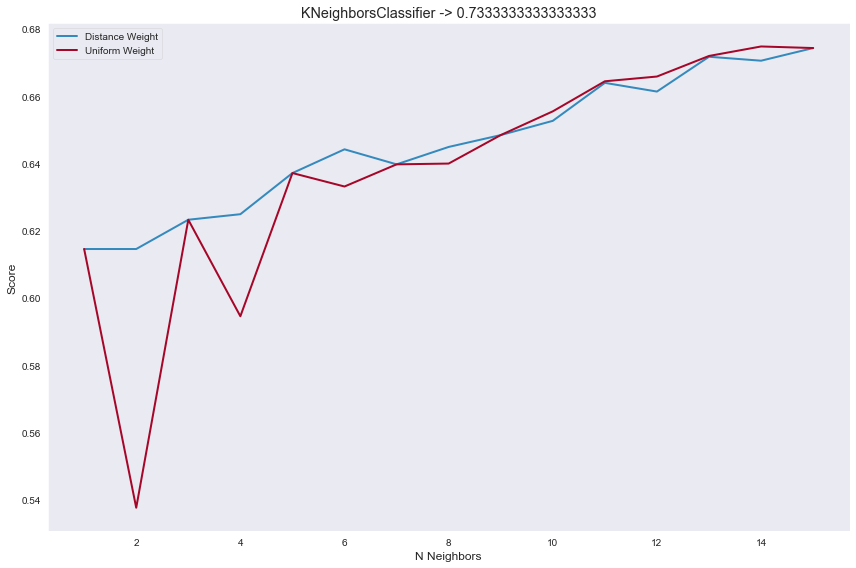

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'distance'],
        label='Distance Weight')
plt.plot(range(1, 16), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'uniform'], 
        label='Uniform Weight')
plt.title(f"KNeighborsClassifier -> {knn.score(df_cf_x_test, df_cf_y_test)}")
plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### Naive-Bayes Classifier 

In [28]:
gnb = GaussianNB().partial_fit(df_cf_x_train, df_cf_y_train, np.unique(df_cf_y_train))
gnb.score(df_cf_x_test, df_cf_y_test)

0.8

##### Decision Tree Classifier

In [29]:
dtc = DecisionTreeClassifier(criterion='entropy').fit(df_cf_x_train, df_cf_y_train)
dtc.score(df_cf_x_test, df_cf_y_test)

0.6

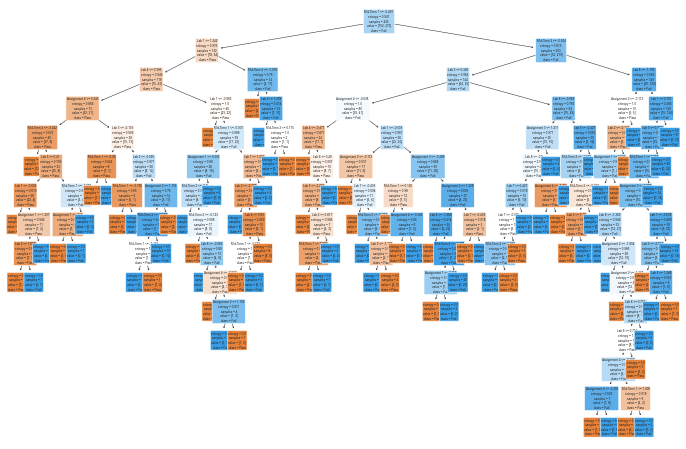

In [30]:
fig = plt.figure(figsize=(12, 8))
dtc_tree = tree.plot_tree(dtc, feature_names=df_cf.columns, class_names=['Pass', 'Fail'], filled=True, rounded=True,
                         fontsize=3)

##### Gradient Boosting Classifier

In [31]:
gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=4, random_state=7, verbose=3, warm_start=True,
                                n_iter_no_change=10).fit(df_cf_x_train, df_cf_y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2405            1.00s
         2           1.1811            1.00s
         3           1.1340            1.16s
         4           1.0893            1.37s
         5           1.0535            1.29s
         6           1.0174            1.24s
         7           0.9832            1.35s
         8           0.9546            1.30s
         9           0.9303            1.27s
        10           0.8997            1.34s
        11           0.8638            1.30s


In [32]:
gbc.score(df_cf_x_test, df_cf_y_test)

0.7333333333333333

####  Evaluating models

In [33]:
models = pd.DataFrame(index=['RandomForestClassifier', 'LogisticRegressionCV', 'KNeighborsClassifier', 
                      'GaussianNB', 'DecisionTreeClassifier', 'GradientBoosting'])
models.index.name="Algorithms"
models['Score'] = np.round([rfc.score(df_cf_x_test, df_cf_y_test), logreg.score(df_cf_x_test, df_cf_y_test), 
                  knn.score(df_cf_x_test, df_cf_y_test), gnb.score(df_cf_x_test, df_cf_y_test), 
                  dtc.score(df_cf_x_test, df_cf_y_test), gbc.score(df_cf_x_test, df_cf_y_test)], 4) * 100
models['f1 Score'] = np.round([f1_score(df_cf_y_test, rfc.predict(df_cf_x_test)), 
                      f1_score(df_cf_y_test, logreg.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, knn.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gnb.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, dtc.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gbc.predict(df_cf_x_test))], 4) * 100
models['Used Model'] = [rfc, logreg, knn, gnb, dtc, gbc]
models = models.sort_values(["Score", 'f1 Score'], ascending=False)
models

,Score,f1 Score,Used Model
Algorithms,,,
GaussianNB,80.00,85.15,GaussianNB()
LogisticRegressionCV,77.33,83.50,LogisticRegressionCV(cv=RepeatedStratifiedKFol...
GradientBoosting,73.33,81.82,([DecisionTreeRegressor(criterion='friedman_ms...
RandomForestClassifier,73.33,80.77,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
KNeighborsClassifier,73.33,80.77,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
DecisionTreeClassifier,60.00,68.09,DecisionTreeClassifier(criterion='entropy')


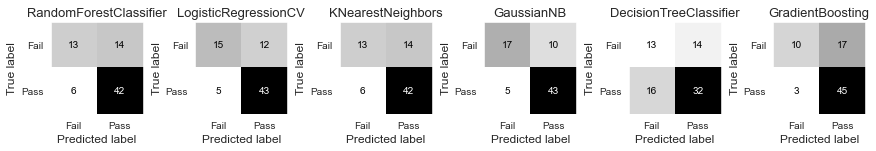

In [34]:
models_list = [rfc, logreg, knn, gnb, dtc, gbc]
model_names = ['RandomForestClassifier', 'LogisticRegressionCV', 'KNearestNeighbors', 'GaussianNB', 
              'DecisionTreeClassifier', 'GradientBoosting']
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gs(nrows=1, ncols=len(models), figure=fig)
for _ in range(len(models)):
    ax = fig.add_subplot(grid[_])
    plot_confusion_matrix(models_list[_], df_cf_x_test, df_cf_y_test, labels=[0, 1],
                         display_labels=['Fail', 'Pass'], colorbar=False, ax=ax, cmap='binary')
    plt.title(f"{model_names[_]}", fontsize=13)
    
plt.show()

### Example 

In [35]:
Lab_1 = 7
Lab_2 = 6
Lab_3 = 6
Lab_4 = 4
Lab_5 = 6
Lab_6 = 8
Lab_7 = 5
Lab_8 = 3

Asgn_1 = 6
Asgn_2 = 4
Asgn_3 = 4
Asgn_4 = 5

MT_1 = 60
MT_2 = 55
        
test = scaler.transform(np.array([Lab_1, Lab_2, Lab_3, Lab_4, Lab_5, Lab_6, Lab_7, Lab_8, 
                                      Asgn_1, Asgn_2, Asgn_3, Asgn_4,
                                      MT_1, MT_2]).reshape(1, -1))
test

array([[ 0.57404815,  0.12624015,  0.11208979, -0.68770844,  0.20095119,
         0.94172435, -0.22144268, -1.1476183 ,  0.11766856, -0.74723806,
        -0.69990942, -0.31686654, -0.57859114, -0.92946063]])

In [36]:
needs = 0.6 - ((((Lab_1 + Lab_2 + Lab_3 + Lab_4 + Lab_5 + Lab_6 + Lab_7 + Lab_8) / 80) * Labs_percent) + \
            (((Asgn_1 + Asgn_2 + Asgn_3 + Asgn_4) / 40) * Assignments_percent) + \
            (((MT_1 + MT_2) / 200) * Mid_term_percent))
[print("Fail") if x == 0 else print("Pass") for x in models.iloc[0]['Used Model'].predict(test)]
print(f"Chance of student passing -> {models.iloc[0]['Used Model'].predict_proba(test)[0][1] * 100:.2f}%")

Fail
Chance of student passing -> 47.99%


### Neural Networks (For fun)

In [37]:
def neural_classifier():
    model = Sequential([Dense(32, input_dim=14), Activation('relu'),
                        Dense(16), Activation('relu'),
                       Dense(1), Activation('sigmoid')])
    model.compile('adam', 'binary_crossentropy', metrics=[metric.BinaryAccuracy()])
    return model

In [38]:
nn_clf = KerasClassifier(build_fn=neural_classifier, epochs=20, batch_size=70, verbose=1)
nn_clf.fit(df_cf_x_train, df_cf_y_train, shuffle=False, validation_data=(df_cf_x_test, df_cf_y_test))

Epoch 1/20
7/7 [==============================] - 1s 48ms/step - loss: 0.9278 - binary_accuracy: 0.3720 - val_loss: 0.8670 - val_binary_accuracy: 0.3467
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.8372 - binary_accuracy: 0.3760 - val_loss: 0.7900 - val_binary_accuracy: 0.3333
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.7732 - binary_accuracy: 0.4212 - val_loss: 0.7344 - val_binary_accuracy: 0.4933
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.7280 - binary_accuracy: 0.4915 - val_loss: 0.6963 - val_binary_accuracy: 0.5600
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6978 - binary_accuracy: 0.5515 - val_loss: 0.6707 - val_binary_accuracy: 0.6133
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6773 - binary_accuracy: 0.5904 - val_loss: 0.6524 - val_binary_accuracy: 0.6000
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6627 - binary_a

In [39]:
print(f"Neural Network probability of passing -> {nn_clf.predict_proba(test)[0][1]*100:.2f}%")

1/1 [==============================] - 0s 54ms/step
Neural Network probability of passing -> 45.72%


In [40]:
f1_score(df_cf_y_test, nn_clf.predict(df_cf_x_test))

2/2 [==============================] - 0s 1ms/step


0.8181818181818181

In [41]:
neural_classifier().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                480       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
____________________________________________________